In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from simplified_monorotor import Monorotor
import plotting
import testing
import trajectories

pylab.rcParams['figure.figsize'] = 10,10

# PID controller

#### TODO - implement PID controller

Implement the PD Controller math in `thrust_control`:

$$
\begin{align}
e &= z_{\text{target}} - z_{\text{actual}} \\
\dot{e} &= \dot{z}_{\text{target}} - \dot{z}_{\text{actual}} \\
\bar{u}_1 &= k_p e + k_d \dot{e} + k_i\int_0^te(t')dt' +\ddot{z}_{\text{ff}} \\
u_1 &= m(g - \bar{u}_1)
\end{align}
$$

> **Note**: we've introduced `integrated_error` and set it to 0.0 at initialization. We also now need to know how much time `dt` has elapsed between successive calls to `thrust_control` as this influences the integrated error.

In [2]:
class PIDController:
    
    def __init__(self, k_p, k_d, k_i, m):
        self.k_p = k_p
        self.k_d = k_d
        self.k_i = k_i
        self.vehicle_mass = m
        self.g = 9.81
        self.integrated_error = 0.0
        
    def thrust_control(self,
                z_target, 
                z_actual, 
                z_dot_target, 
                z_dot_actual,
                dt=0.1,
                z_dot_dot_ff=0.0):
        #
        # TODO
        #   implement a PID controller according to the math
        #   shown above. Remember that the integral accumulates
        #   error by adding "rectangles" of error with area
        #   equal to err * dt
        #
        #   don't forget to return a thrust command
        #
    
        err = z_target - z_actual
        err_dot = z_dot_target - z_dot_actual
        self.integrated_error += err * dt
        
        p = self.k_p * err
        i = self.k_i * self.integrated_error 
        d = self.k_d * err_dot
         
        u_bar = p + i + d + z_dot_dot_ff
        u = self.vehicle_mass * (self.g - u_bar)
        return u
    
testing.pid_controller_test(PIDController)

Tests pass


#### TODO 2 - Adjust gains
Run the simulation code below with `K_I = 0.0` to remind yourself what a PD controller does when there's a large mass_error (remember, a PID controller with zero integral gain is just a PD controller).

Then slowly increase `K_I` and rerun the cell. Note what happens to the error.

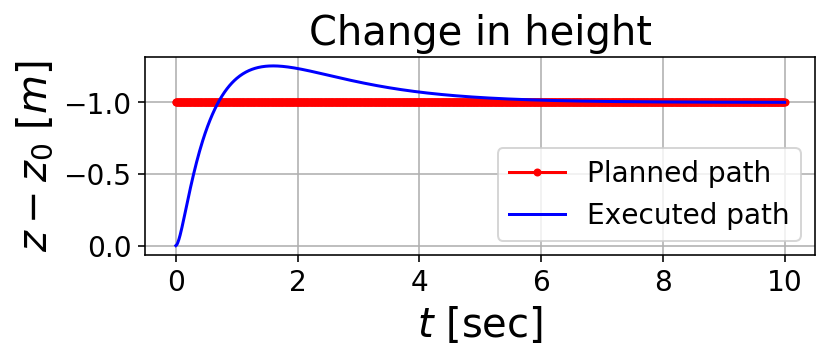

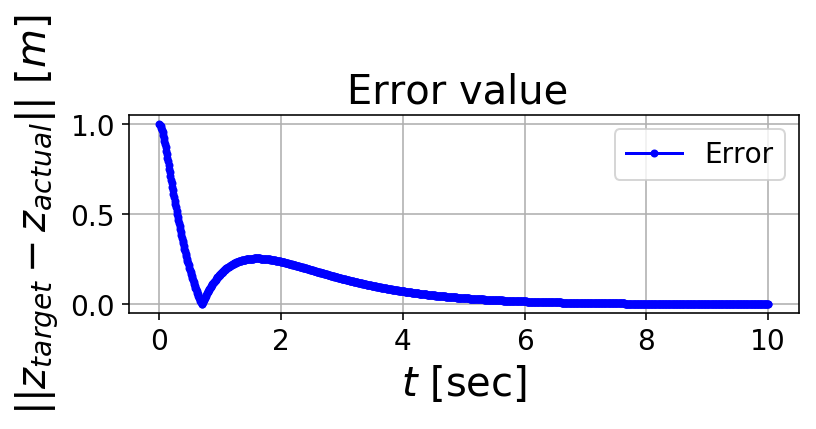

In [6]:
MASS_ERROR = 1.5
K_P = 20.0
K_D = 10.0
K_I = 10 # TODO - increase to 0.5, 1, 2, etc...

# AMPLITUDE = 0.5
# PERIOD    = 0.4

# preparation 
drone = Monorotor()
perceived_mass = drone.m * MASS_ERROR
controller    = PIDController(K_P, K_D, K_I, perceived_mass)

t, z_path, z_dot_path = trajectories.step(duration=10.0)

dt = t[1] - t[0]

# run simulation
history = []
for z_target, z_dot_target in zip(z_path, z_dot_path):
    z_actual = drone.z
    z_dot_actual = drone.z_dot
    z_dot_dot_ff = 0

    u = controller.thrust_control(z_target, z_actual, 
                                  z_dot_target, z_dot_actual,
                                  dt, z_dot_dot_ff)
    
    drone.thrust = u
    drone.advance_state(dt)
    history.append(drone.X)
    
# generate plots
z_actual = [h[0] for h in history]
plotting.compare_planned_to_actual(z_actual, z_path, t)   

Hopefully you were able to adjust K_P, K_D, and K_I so that the drone gets to the target altitude (even with a large mass error) pretty quickly.

If so, congratulations! You now understand PID control!

[Solution](/notebooks/PID%20Controller%20Solution.ipynb)